In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def orientation(w,tau):
    return np.sqrt(2/tau)*w

def x_position(theta,v,dt):
    return v*np.cos(theta)*dt

def y_position(theta,v,dt):
    return v*np.sin(theta)*dt


def ligth_intensity_each_robot(I_0,r_0,x,y,num_robots,step):
    I = np.zeros(num_robots)
    
    for i in range(num_robots):
        for j in range(num_robots):
            if i != j:
                distance_squared = (x[j,step] - x[i,step])**2 + (y[j,step] - y[i,step])**2
                I[i] += I_0 * np.exp(-distance_squared / r_0**2)
    return I

def velocity(v_inf,v_0,I):      # eq 10.2
    return v_inf + (v_0 - v_inf)*np.exp(-I)

def velocity_with_delay(v_inf,v_0,I,step_current,delta,dt):
    time = step_current*dt
    if delta > 0 :
        step_delay = int((time - delta))       #find step of light which robot reacts
        I_delay = I[:,step_delay]
        return v_inf + (v_0 - v_inf)*np.exp(-I_delay)
    elif delta < 0:
        step_delay = int((time - delta)/dt)
        slope = (I[:,step_current]-I[:,step_current-1])/dt
        I_delay = I[:,step_current] - delta*slope*step_delay
        # ensure that I_delay >= 0
        I_delay = np.maximum(0,I_delay)
        return v_inf + (v_0 - v_inf)*np.exp(-I_delay)
    else:
        I_delay = I[:,step_current]
        return v_inf + (v_0 - v_inf)*np.exp(-I_delay)


def distance_from_center(x,y):
    return np.sqrt(np.square(x),np.square(y))

In [25]:
#Parameters
n_robots = 50      #no. of robots
L = 10              #side of box
tau = 2             #s
r_0 = 1             #m
I_0 = 5             #W

dt = 1e-2       #time step
v_0 = 1         #maximum speed
v_inf = 0.1     #minimum speed

total_steps = 10**5

In [ ]:
delta_list = [0,10,-10]
step_list = [1,9999,99999]  #snapshot at 0, 100,1000 s


snapshots_no_delay = []
snapshots_positive_delay = []
snapshots_negative_delay = []
for i,delta in enumerate(delta_list):
   
    x = np.zeros((n_robots,total_steps))
    y = np.zeros((n_robots,total_steps))
    theta = np.zeros((n_robots,total_steps))
    intensity = np.zeros((n_robots,total_steps))

    # initialize v
    v = np.ones(n_robots)*v_inf   

    # White-noise
    W = np.random.normal(0, 1, size=(n_robots, total_steps))

    # Random initial position of each robot
    x[:,0] = np.random.rand(n_robots) * L
    y[:,0] = np.random.rand(n_robots) * L

    for step in range(1,total_steps):
        w = W[:,step]
        theta[:,step] = orientation(w,tau) + theta[:,step-1]
        x[:,step] = x_position(theta[:,step],v,dt) + x[:,step-1]
        y[:,step] = y_position(theta[:,step],v,dt) + y[:,step-1]
        
        # Boundary check
        x[:,step] = np.maximum(0, np.minimum(x[:,step], L))  # Ensure x stays within [0, L]
        y[:,step] = np.maximum(0, np.minimum(y[:,step], L))
    

        # Compute ligth intensity of each robots
        intensity[:,step] = ligth_intensity_each_robot(I_0,r_0,x,y,n_robots,step)

        # Update v
        v = velocity_with_delay(v_inf,v_0,intensity,step,delta,dt)

        if step in step_list:
            if delta == 0:
                snapshots_no_delay.append((delta,step,x.copy(),y.copy()))
            elif delta > 0:
                snapshots_positive_delay.append((delta,step,x.copy(),y.copy()))
            else:
                snapshots_negative_delay.append((delta,step,x.copy(),y.copy()))



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


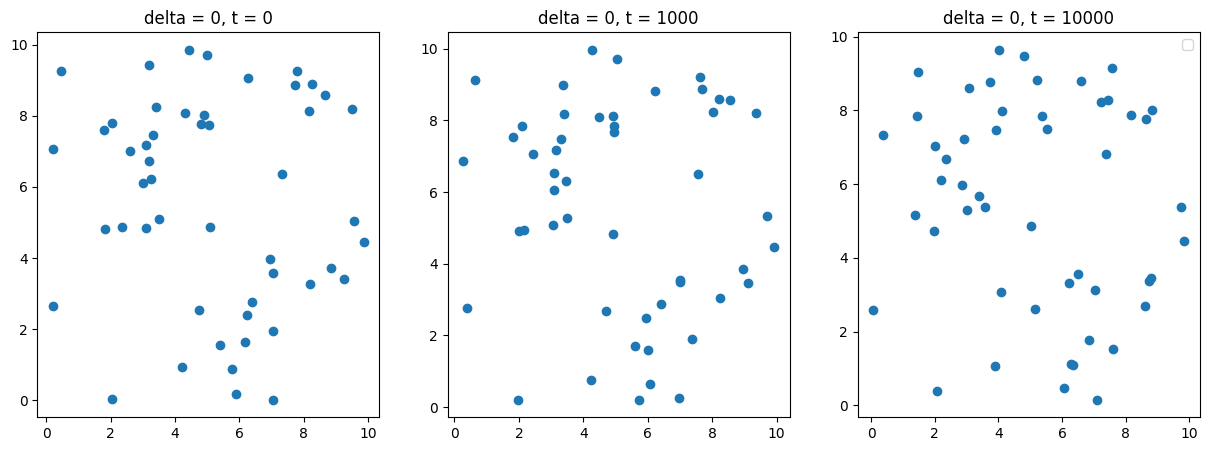

In [26]:
#delta  = 0
delta = 0
x = np.zeros((n_robots,total_steps))
y = np.zeros((n_robots,total_steps))
theta = np.zeros((n_robots,total_steps))
I = np.zeros((n_robots,total_steps))

# initialize v
v = np.ones(n_robots)*v_inf   

# White-noise
W = np.random.normal(0, 1, size=(n_robots, total_steps))

# Random initial position of each robot
x[:,0] = np.random.rand(n_robots) * L
y[:,0] = np.random.rand(n_robots) * L

for step in range(1,total_steps):
    # Compute ligth intensity of each robots
    I[:,step] = ligth_intensity_each_robot(I_0,r_0,x,y,n_robots,step)
    

    # Update v
    if delta > 0:
        step_delay = int(step - delta)     
        I_delay = I[:,step_delay]
        v = v_inf + (v_0 - v_inf)*np.exp(-I_delay)
        
    elif delta < 0:
        #step_delay = int((step_current - delta))
        slope = (I[:,step]-I[:,step-1])
        I_delay = I[:,step] - delta*slope
        
        v = v_inf + (v_0 - v_inf)*np.exp(-I_delay)
    
    else:
        I_delay = I[:,step]
        v = v_inf + (v_0 - v_inf)*np.exp(-I_delay)
    #v = velocity_with_delay(v_inf,v_0,I,step,delta,dt)
    
    w = W[:,step]
    theta[:,step] = orientation(w,tau) + theta[:,step-1]
    x[:,step] = x_position(theta[:,step],v,dt) + x[:,step-1]
    y[:,step] = y_position(theta[:,step],v,dt) + y[:,step-1]
    
    # Boundary check
    x[:,step] = np.maximum(0, np.minimum(x[:,step], L))  # Ensure x stays within [0, L]
    y[:,step] = np.maximum(0, np.minimum(y[:,step], L))


#plot

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(x[:,0],y[:,0])
plt.title(f'delta = {delta}, t = 0')

plt.subplot(1,3,2)
plt.scatter(x[:,9999],y[:,9999])
plt.title(f'delta = {delta}, t = 1000')

plt.subplot(1,3,3)
plt.scatter(x[:,99999],y[:,99999])
plt.title(f'delta = {delta}, t = 10000')
plt.legend()

Text(0.5, 1.0, 'delta = 10, t = 10000')

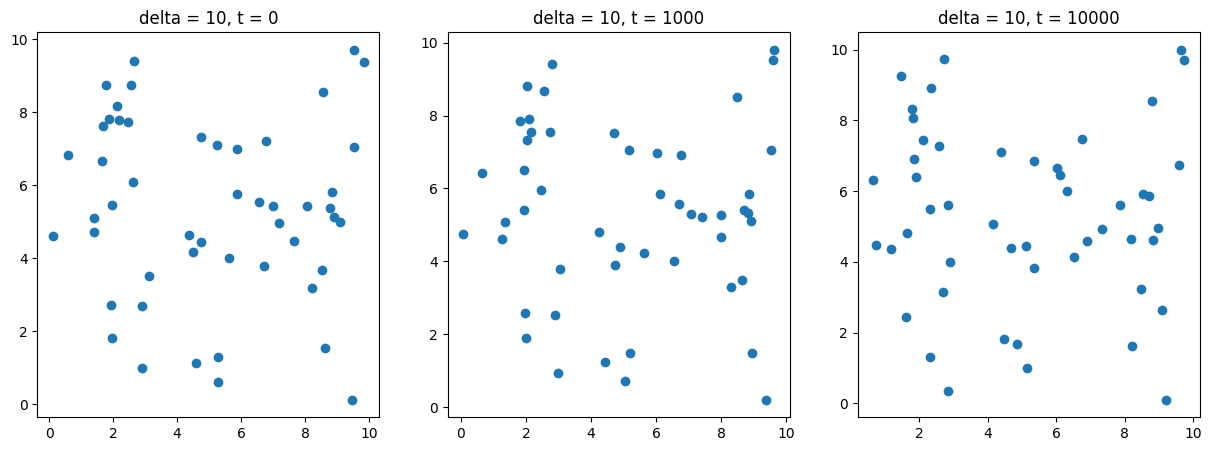

In [27]:
#delta  = 10
delta = 5*tau
x = np.zeros((n_robots,total_steps))
y = np.zeros((n_robots,total_steps))
theta = np.zeros((n_robots,total_steps))
intensity = np.zeros((n_robots,total_steps))

# initialize v
v = np.ones(n_robots)*v_inf   

# White-noise
W = np.random.normal(0, 1, size=(n_robots, total_steps))

# Random initial position of each robot
x[:,0] = np.random.rand(n_robots) * L
y[:,0] = np.random.rand(n_robots) * L


for step in range(1,total_steps):
    # Compute ligth intensity of each robots
    I[:,step] = ligth_intensity_each_robot(I_0,r_0,x,y,n_robots,step)


    # Update v
    if delta > 0:
        step_delay = int(step - delta)     
        I_delay = I[:,step_delay]
        v = v_inf + (v_0 - v_inf)*np.exp(-I_delay)

    elif delta < 0:
        #step_delay = int((step_current - delta))
        slope = (I[:,step]-I[:,step-1])
        I_delay = I[:,step] - delta*slope

        v = v_inf + (v_0 - v_inf)*np.exp(-I_delay)

    else:
        I_delay = I[:,step]
        v = v_inf + (v_0 - v_inf)*np.exp(-I_delay)
    #v = velocity_with_delay(v_inf,v_0,I,step,delta,dt)

    w = W[:,step]
    theta[:,step] = orientation(w,tau) + theta[:,step-1]
    x[:,step] = x_position(theta[:,step],v,dt) + x[:,step-1]
    y[:,step] = y_position(theta[:,step],v,dt) + y[:,step-1]

    # Boundary check
    x[:,step] = np.maximum(0, np.minimum(x[:,step], L))  # Ensure x stays within [0, L]
    y[:,step] = np.maximum(0, np.minimum(y[:,step], L))


#plot

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(x[:,0],y[:,0])
plt.title(f'delta = {delta}, t = 0')

plt.subplot(1,3,2)
plt.scatter(x[:,9999],y[:,9999])
plt.title(f'delta = {delta}, t = 1000')

plt.subplot(1,3,3)
plt.scatter(x[:,99999],y[:,99999])
plt.title(f'delta = {delta}, t = 10000')


Text(0.5, 1.0, 'delta = -10, t = 10000')

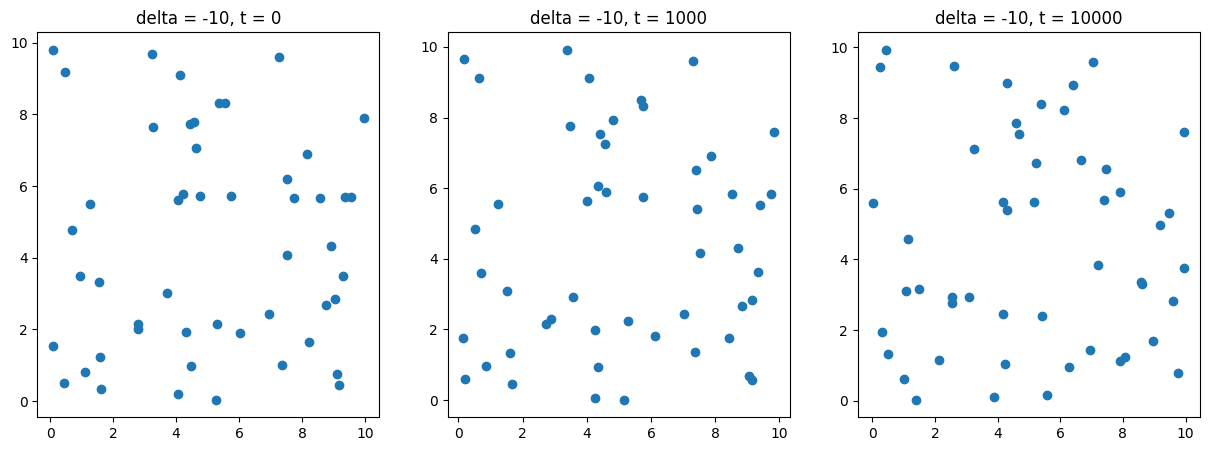

In [28]:
#delta  = -5
delta = -5*tau
x = np.zeros((n_robots,total_steps))
y = np.zeros((n_robots,total_steps))
theta = np.zeros((n_robots,total_steps))
intensity = np.zeros((n_robots,total_steps))

# initialize v
v = np.ones(n_robots)*v_inf   

# White-noise
W = np.random.normal(0, 1, size=(n_robots, total_steps))

# Random initial position of each robot
x[:,0] = np.random.rand(n_robots) * L
y[:,0] = np.random.rand(n_robots) * L

for step in range(1,total_steps):
    # Compute ligth intensity of each robots
    I[:,step] = ligth_intensity_each_robot(I_0,r_0,x,y,n_robots,step)
    

    # Update v
    if delta > 0:
        step_delay = int(step - delta)     
        I_delay = I[:,step_delay]
        v = v_inf + (v_0 - v_inf)*np.exp(-I_delay)
        
    elif delta < 0:
        #step_delay = int((step_current - delta))
        slope = (I[:,step]-I[:,step-1])
        I_delay = I[:,step] - delta*slope
        
        v = v_inf + (v_0 - v_inf)*np.exp(-I_delay)
    
    else:
        I_delay = I[:,step]
        v = v_inf + (v_0 - v_inf)*np.exp(-I_delay)
    #v = velocity_with_delay(v_inf,v_0,I,step,delta,dt)
    
    w = W[:,step]
    theta[:,step] = orientation(w,tau) + theta[:,step-1]
    x[:,step] = x_position(theta[:,step],v,dt) + x[:,step-1]
    y[:,step] = y_position(theta[:,step],v,dt) + y[:,step-1]
    
    # Boundary check
    x[:,step] = np.maximum(0, np.minimum(x[:,step], L))  # Ensure x stays within [0, L]
    y[:,step] = np.maximum(0, np.minimum(y[:,step], L))

#plot

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(x[:,0],y[:,0])
plt.title(f'delta = {delta}, t = 0')

plt.subplot(1,3,2)
plt.scatter(x[:,9999],y[:,9999])
plt.title(f'delta = {delta}, t = 1000')

plt.subplot(1,3,3)
plt.scatter(x[:,99999],y[:,99999])
plt.title(f'delta = {delta}, t = 10000')
